

---

---
# Previsão de ações da Petrobrás 

Este notebook implementa uma Rede Neural Recorrente (RNN - *Recurrent Neural Net*) para prever o comportamento de ações da Petrobrás.


---

---







## Conjuntos de dados

Fonte: https://br.financas.yahoo.com/quote/PETR4.SA/history?p=PETR4.SA

- Dados de treinamento: valores de abertura (*Open*) da bolsa no período de 02-01-2015 até 27-12-2019 (arquivo: **PETR4_train.csv**)

- Dados de teste: valores de abertura (*Open*) da bolsa no período de 02-01-2020 até 30-12-2020 (arquivo: **PETR4_test.csv**)

- Defasagem ou lag (*timesteps*): 90 dias



## Leitura e preparação dos dados

Vamos começar importando o arquivo CSV com a base de dados usando o Pandas.

In [ ]:
import pandas as pd
# Clone do repositório de dados do GitHub
!git clone https://github.com/malegopc/AM2PUCPOC
# lê arquivo de dados
dataset_train = pd.read_csv('/content/AM2PUCPOC/Datasets/Ações_Petro/PETR4_train.csv')
# mostra os dados
dataset_train

fatal: destination path 'AM2PUCPOC' already exists and is not an empty directory.


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,9.990000,9.99,9.350000,9.360000,8.683293,49559500.0
1,2015-01-05,9.140000,9.19,8.530000,8.560000,7.941135,78385100.0
2,2015-01-06,8.710000,8.83,8.040000,8.280000,7.681378,84723300.0
3,2015-01-07,8.560000,8.73,8.360000,8.670000,8.043181,85531000.0
4,2015-01-08,8.790000,9.39,8.740000,9.230000,8.562695,83306300.0
...,...,...,...,...,...,...,...
1237,2019-12-19,30.450001,30.75,30.420000,30.610001,30.189920,39696000.0
1238,2019-12-20,30.600000,30.60,30.020000,30.260000,29.844723,93064900.0
1239,2019-12-23,30.190001,30.50,30.030001,30.500000,30.081429,21970200.0
1240,2019-12-26,30.590000,30.93,30.500000,30.910000,30.485802,24810500.0


## Análise prévia dos dados

Imprime o número de dados non-null (não ausentes) e o tipo de cada atributo.

In [ ]:
# Mostra o número de dados non-null (não ausentes) e o tipo de cada atributo
print('Informações sobre os dados:\n')
dataset_train.info()
# Soma o número de dados null (ausentes)
print('\n\nSoma de dados null (vazios):\n')
dataset_train.isnull().sum()

Informações sobre os dados:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1242 non-null   object 
 1   Open       1240 non-null   float64
 2   High       1240 non-null   float64
 3   Low        1240 non-null   float64
 4   Close      1240 non-null   float64
 5   Adj Close  1240 non-null   float64
 6   Volume     1240 non-null   float64
dtypes: float64(6), object(1)
memory usage: 68.0+ KB


Soma de dados null (vazios):



Date         0
Open         2
High         2
Low          2
Close        2
Adj Close    2
Volume       2
dtype: int64

## Eliminação das linhas null

In [ ]:
dataset_train = dataset_train.dropna()
print('Soma de dados null (vazios):\n')
dataset_train.isnull().sum()

Soma de dados null (vazios):



Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Dimensão da base de dados

In [ ]:
dataset_train.shape

(1240, 7)

## Separa os atributos de treinamento

Extrai a coluna "Open" (valores de abertura da ação).


In [ ]:
training_set = dataset_train.iloc[:, 1:2].values # coluna 1
print(training_set)
print(training_set.shape)

[[ 9.99    ]
 [ 9.14    ]
 [ 8.71    ]
 ...
 [30.190001]
 [30.59    ]
 [30.690001]]
(1240, 1)


## Escalonamento dos dados

Mapeia (transforma) os dados para o intervalo [0,1].

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

## Gráfico dos dados originais e escalonados

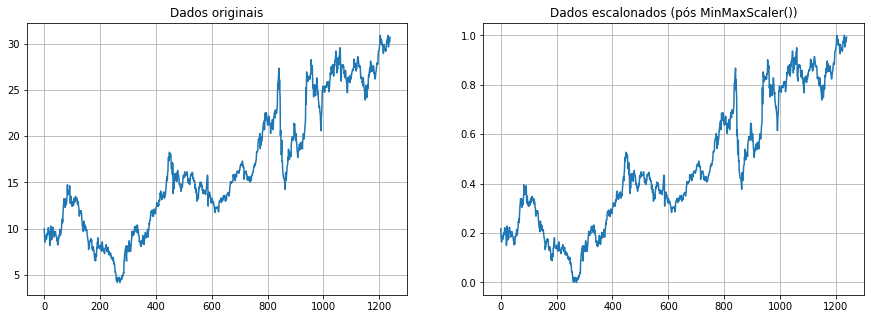

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title("Dados originais")
plt.plot(training_set)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Dados escalonados (pós MinMaxScaler())")
plt.plot(training_set_scaled)
plt.grid(True)
plt.show()

## Cria estrutura de dados de treinamento 

Cria uma estrutura de dados de treinamento com sequências (*timesteps*) de 90 dias e uma saída (*target*).

In [ ]:
import numpy as np
X_train = [] # cria listas para os atributos e target
y_train = [] 
timesteps = 90 # defasagem ou lag
for i in range(timesteps, len(training_set)):
    X_train.append(training_set_scaled[i-timesteps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

## Redimensiona o array de treinamento

Redimensiona o array de treinamento de modo que fica com as dimensões exigidas pela classe SimpleRNN (um tensor 3D na forma [batch, timesteps, feature]).

Ver: https://keras.io/api/layers/recurrent_layers/simple_rnn/

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1150, 90, 1)

## Construção da RNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

model = Sequential()
# 1a. camada SimpleRNN 
model.add(SimpleRNN(40, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.3))
# 2a. camada SimpleRNN 
model.add(SimpleRNN(40))
model.add(Dropout(0.3))
# Camada de saída da rede (uma unidade)
model.add(Dense(1))

## Sumário da rede neural

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 90, 40)            1680      
_________________________________________________________________
dropout (Dropout)            (None, 90, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


## Compilação da rede neural

In [ ]:
model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

## Ajuste e treinamento da rede neural

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='mean_absolute_error', min_delta = 1e-10, patience=10, restore_best_weights = 'True', verbose=1)
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, callbacks=[early_stop])

Epoch 1/100
36/36 [==============================] - 24s 37ms/step - loss: 0.2214 - mean_absolute_error: 0.3409
Epoch 2/100
36/36 [==============================] - 1s 39ms/step - loss: 0.0642 - mean_absolute_error: 0.1934
Epoch 3/100
36/36 [==============================] - 1s 35ms/step - loss: 0.0357 - mean_absolute_error: 0.1394
Epoch 4/100
36/36 [==============================] - 1s 37ms/step - loss: 0.0248 - mean_absolute_error: 0.1145
Epoch 5/100
36/36 [==============================] - 1s 34ms/step - loss: 0.0194 - mean_absolute_error: 0.0969
Epoch 6/100
36/36 [==============================] - 1s 33ms/step - loss: 0.0142 - mean_absolute_error: 0.0867
Epoch 7/100
36/36 [==============================] - 1s 31ms/step - loss: 0.0116 - mean_absolute_error: 0.0793
Epoch 8/100
36/36 [==============================] - 1s 31ms/step - loss: 0.0095 - mean_absolute_error: 0.0696
Epoch 9/100
36/36 [==============================] - 1s 32ms/step - loss: 0.0083 - mean_absolute_error: 0.0662


## Análise da função *loss* (erro/perda)
Comportamento da função *loss* para os dados de treino e de validação.

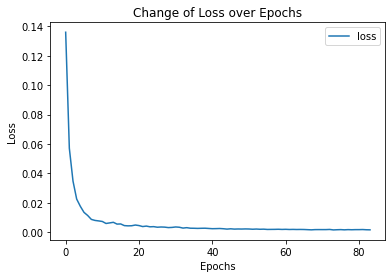

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.title('Change of Loss over Epochs')
plt.legend(['loss'])
plt.show()

## Leitura do conjunto de dados de teste

Leitura dos dados de teste para fazer a previsão dos valores de abertura das ações no primero ano de 2020.

In [ ]:
dataset_test = pd.read_csv('/content/AM2PUCPOC/Datasets/Ações_Petro/PETR4_test.csv')
dataset_test

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,30.510000,30.700001,30.309999,30.700001,30.697731,37774500.0
1,2020-01-03,30.879999,31.240000,30.450001,30.450001,30.447748,71595600.0
2,2020-01-06,30.430000,30.940001,29.950001,30.809999,30.807720,81844000.0
3,2020-01-07,30.820000,30.879999,30.469999,30.690001,30.687731,32822000.0
4,2020-01-08,30.690001,30.770000,30.240000,30.500000,30.497744,48215600.0
...,...,...,...,...,...,...,...
243,2020-12-22,27.200001,27.469999,27.049999,27.280001,27.280001,46513200.0
244,2020-12-23,27.430000,28.250000,27.350000,27.950001,27.950001,49038900.0
245,2020-12-28,28.360001,28.520000,28.180000,28.180000,28.180000,36313300.0
246,2020-12-29,28.379999,28.430000,27.990000,28.270000,28.270000,29891100.0


## Análise prévia dos dados de teste

Verifica se há dados null.

In [ ]:
# Soma o número de dados null (ausentes)
print('\n\nSoma de dados null (vazios):\n')
dataset_test.isnull().sum()



Soma de dados null (vazios):



Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

## Eliminação das linhas null dos dados de teste

In [ ]:
dataset_test = dataset_test.dropna()
print('Soma de dados null (vazios):\n')
dataset_test.isnull().sum()

Soma de dados null (vazios):



Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Dimensão da base de dados de teste

In [ ]:
dataset_test.shape

(247, 7)

## Separa os atributos de treinamento

Extrai a coluna "Open" (valores de abertura da ação) da base de dados de teste.


In [ ]:
valor_real = dataset_test.iloc[:, 1:2].values # coluna 1
print(valor_real)
print(valor_real.shape)

[[30.51    ]
 [30.879999]
 [30.43    ]
 [30.82    ]
 [30.690001]
 [30.469999]
 [30.389999]
 [30.35    ]
 [30.23    ]
 [29.9     ]
 [29.6     ]
 [29.719999]
 [29.700001]
 [29.799999]
 [29.73    ]
 [29.09    ]
 [29.559999]
 [28.629999]
 [28.43    ]
 [29.      ]
 [28.280001]
 [28.629999]
 [28.52    ]
 [28.65    ]
 [29.049999]
 [28.700001]
 [29.      ]
 [28.889999]
 [29.4     ]
 [29.639999]
 [29.77    ]
 [29.860001]
 [29.629999]
 [29.059999]
 [29.870001]
 [30.799999]
 [29.51    ]
 [25.719999]
 [25.16    ]
 [25.5     ]
 [26.57    ]
 [26.91    ]
 [26.33    ]
 [24.1     ]
 [17.809999]
 [18.65    ]
 [16.700001]
 [13.66    ]
 [15.1     ]
 [12.91    ]
 [13.6     ]
 [11.79    ]
 [11.07    ]
 [13.11    ]
 [12.11    ]
 [12.57    ]
 [13.24    ]
 [14.4     ]
 [13.3     ]
 [13.15    ]
 [13.6     ]
 [13.45    ]
 [15.4     ]
 [16.299999]
 [16.049999]
 [16.610001]
 [16.5     ]
 [17.940001]
 [16.82    ]
 [17.02    ]
 [16.040001]
 [16.67    ]
 [15.75    ]
 [15.48    ]
 [15.85    ]
 [17.200001]
 [16.690001]

## Monta a estrutura de dados de teste



In [ ]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0) # concatena dados de treino e teste
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values # armazena em inputs os 90 últimos dados de train + dados de test
inputs = inputs.reshape(-1,1) # remodela com uma coluna
inputs = sc.transform(inputs) # escalonamento dos dados (minmax)
X_test = []
for i in range(timesteps, len(inputs)):  
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # redimensiona para um tensor 3D na forma [batch, timesteps, feature]
valor_previsto = model.predict(X_test)
valor_previsto = sc.inverse_transform(valor_previsto) # mapeia os valores para a escala original

### Visualização dos resultados

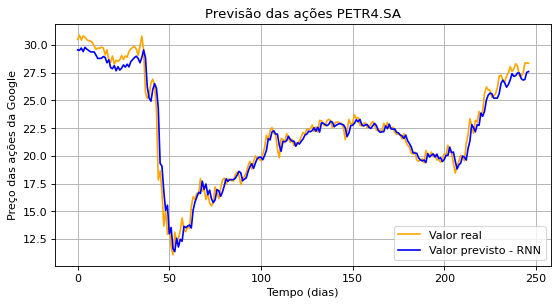

In [ ]:
plt.figure(figsize=(8,4), dpi = 80, facecolor='w', edgecolor='k')
plt.plot(valor_real, color = 'orange', label = 'Valor real')
plt.plot(valor_previsto, color = 'blue', label = 'Valor previsto - RNN')
plt.title('Previsão das ações PETR4.SA')
plt.xlabel('Tempo (dias)')
plt.ylabel('Preço das ações da Google')
plt.grid(True)
plt.legend()
plt.show()